In [33]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jaccard



In [2]:
### Read a visualize to dataset (games) ###

df_games = pd.read_csv('data/games.csv')
df_games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


In [3]:
### Read a visualize to dataset (users) ###

# We randomly generate a list of game (app_id) which are supposed to represent the user's last played games.
# It is random because it is difficult to extract real data for this. Plus, we do not really need real data for our experiments here.

df_gen_users = pd.read_csv('data/generated_users.csv')
df_gen_users.head()

,steam_id,appids
0,76561198012345678,"570,730,440,550,271590"
1,76561198023456789,"1085660,381210,105600,252950,620"
2,76561198034567890,"230410,292030,1172620,582010,359550"
3,76561198045678901,"413150,294100,227300,435150,386360"
4,76561198056789012,"346110,377160,221100,252490,239140"


In [4]:
### Read a visualize to dataset (tags) ###

# The data is from the following Kaggle dataset : https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games_metadata.json
# We isolated manually the 'app_id' and the 'tags' from the JSON file putting separators and using Excel to convert it into a CSV file

#Read the input CSV file
df_tags = pd.read_csv('data/game_tags.csv', ';')
df_tags.head()

TypeError: read_csv() takes 1 positional argument but 2 were given

In [83]:
### PRE-PROCESSING (part 1) ###
# -> Extract the list of unique game tags

#Select tags from the dataframe and transform the strings into lists
df_tags_string = df_tags['tags'].str.split(',')

#Split tags into one row for each, we delete duplicate values
df_tags_list = df_tags_string.explode().drop_duplicates()

#We extract the result
list_tags = df_tags_list.tolist()

#Save the result in a file (optional)
with open('data/unique_tags_list.txt', 'w') as output_file:
        for tag in list_tags:
            output_file.write(str(tag) + '\n')


In [5]:
### PRE-PROCESSING (part 2) ###
# -> Create the game matrix where each row is game and the colomns are all the unique game tags (matrix size~ 47456 x 442)

game_tag_matrix = pd.DataFrame("0", index=df_tags['app_id'], columns=list_tags)
game_tag_matrix.head()

NameError: name 'df_tags' is not defined

In [85]:
### PRE-PROCESSING (part 3) ###
# -> For each games, read its tags, and put a 1 in the corresponding colomn
        
for index, row in df_tags.iterrows(): 
    app_id = row["app_id"]
    app_tags = str(row["tags"]).split(',')
    for tag in app_tags:
        game_tag_matrix.loc[app_id, tag] = "1"

game_tag_matrix.to_csv('data/matrix_game_tags.csv', encoding='utf-8')
#=> We can now use the 'game_tag_matrix' for the dimentionality reduction !

# Note : We can ignore the game that have only the tag 'nan'


In [90]:
# Verification of the tag list in matrix.csv
list_tags_matrix = "app_id,Zombies,World War II,FPS,Multiplayer,Action,Shooter,Co-op,Singleplayer,Moddable,First-Person,War,Online Co-Op,Gore,Historical,Classic,Survival,Great Soundtrack,Tanks,Horror,Adventure,Parkour,Third Person,Platformer,Time Travel,Atmospheric,Hack and Slash,Time Manipulation,Fantasy,Story Rich,Dark,Open World,Controller,Dark Fantasy,Puzzle,Stealth,Indie,Heist,Local Co-Op,Strategy,Top-Down,Crime,Casual,Pixel Graphics,Local Multiplayer,2D,Loot,Cartoony,Survival Horror,Third-Person Shooter,Anime,Roguelike,Tower Defense,RPG,Sci-fi,Dungeon Crawler,Perma Death,Procedural Generation,Resource Management,Difficult,Roguelite,Replay Value,Arcade,Side Scroller,Retro,Shoot 'Em Up,Old School,Nostalgia,Comedy,Action RPG,Magic,Female Protagonist,Nudity,Action-Adventure,Medieval,Sandbox,Simulation,Character Customization,Horses,Realistic,Early Access,RTS,JRPG,Cute,Funny,Turn-Based,Visual Novel,Turn-Based Combat,Memes,Tactical,LEGO,Family Friendly,Split Screen,3D Platformer,Grand Strategy,Relaxing,Physics,Ambient,Minimalist,Space,Science,Education,Flight,Isometric,CRPG,Violent,Exploration,Mystery,Walking Simulator,Short,Psychological Horror,Post-apocalyptic,Addictive,Dark Humor,Building,Action Roguelike,Metroidvania,Otome,Dating Sim,Romance,Choices Matter,1990's,Free to Play,Mechs,Robots,Massively Multiplayer,PvP,Team-Based,Utilities,Software,Voxel,Point & Click,Alternate History,Drama,Hidden Object,LGBTQ+,MOBA,Fighting,Action RTS,Soundtrack,Turn-Based Strategy,City Builder,Cartoon,Turn-Based Tactics,Rhythm,Music,Cyberpunk,Episodic,Futuristic,Kickstarter,Choose Your Own Adventure,Twin Stick Shooter,4 Player Local,Top-Down Shooter,Political,Fast-Paced,Puzzle Platformer,Surreal,Abstract,Philosophical,Psychedelic,Psychological,Supernatural,2.5D,Multiple Endings,2D Platformer,Narrative,Cats,Score Attack,Remake,Linear,Sports,Party-Based RPG,Cult Classic,Steampunk,Racing,Automobile Sim,Destruction,Driving,Open World Survival Craft,Crafting,Base Building,Aliens,4X,Management,Time Management,Real Time Tactics,Blood,Hand-drawn,Text-Based,Interactive Fiction,Political Sim,Runner,Bikes,Motorbike,Emotional,VR,Detective,Dark Comedy,Mature,Baseball,Football (Soccer),Strategy RPG,Tactical RPG,Colorful,Grid-Based Movement,Sexual Content,Minigames,Beautiful,Animation & Modeling,Design & Illustration,Game Development,3D,3D Vision,3D Fighter,Boxing,Co-op Campaign,Real-Time,Ninja,Souls-like,Gothic,Satire,Board Game,Chess,2D Fighter,Competitive,Pool,Snooker,Naval Combat,Pirates,Naval,Trading,Sailing,Economy,MMORPG,Thriller,Trivia,Party,Party Game,Video Production,Military,Wargame,Combat,Foreign,Lovecraftian,FMV,Noir,Dystopian,Cold War,Mod,Snow,Narration,Modern,Underwater,Spectacle fighter,Fishing,Mythology,NSFW,Illuminati,Demons,Assassin,Audio Production,Battle Royale,God Game,Epic,Faith,Colony Sim,RPGMaker,Level Editor,Stylized,Trains,Diplomacy,Character Action Game,Life Sim,Nonlinear,Collectathon,Transportation,Immersive Sim,Dungeons & Dragons,Hacking,Dragons,PvE,Cinematic,Arena Shooter,Clicker,Parody,GameMaker,Card Game,Asynchronous Multiplayer,Asymmetric VR,Martial Arts,Villain Protagonist,Word Game,Medical Sim,Bullet Hell,Capitalism,Lore-Rich,Experience,Immersive,Swordplay,Roguelike Deckbuilder,Card Battler,Deckbuilding,Escape Room,Investigation,Tabletop,Hentai,6DOF,Idler,Job Simulator,Logic,Offroad,ATV,0TrackIR,Dynamic Narration,Pinball,Real-Time with Pause,Wrestling,Mouse only,Superhero,1980s,Match 3,Beat 'em up,Based On A Novel,Dinosaurs,Conversation,Tutorial,Comic Book,Programming,Nature,Submarine,Farming Sim,Vampire,Mining,Automation,Touch-Friendly,Cooking,On-Rails Shooter,Bullet Time,Gun Customization,Sniper,Outbreak Sim,Silent Protagonist,Auto Battler,Dog,Western,Artificial Intelligence,Rock Music,Politics,Crowdfunded,Photo Editing,Solitaire,Gambling,Combat Racing,Vehicular Combat,Hex Grid,Vikings,Precision Platformer,Transhumanism,Shop Keeper,Wholesome,Agriculture,Experimental,Social Deduction,Spelling,Basketball,Golf,Class-Based,Sequel,Movie,Unforgiving,Creature Collector,Rome,360 Video,Time Attack,Music-Based Procedural Generation,America,Looter Shooter,Motocross,Inventory Management,eSports,Werewolves,Space Sim,Conspiracy,Typing,Jet,Games Workshop,Warhammer 40K,Trading Card Game,Hunting,Mystery Dungeon,Underground,Mini Golf,Traditional Roguelike,Sokoban,Web Publishing,Jump Scare,Cozy,Hero Shooter,Gaming,Spaceships,Football (American),Skiing,Mars,Well-Written,World War I,Software Training,Tennis,Archery,Cycling,BMX,Quick-Time Events,Electronic Music,Boss Rush,Skateboarding,Skating,Voice Control,Instrumental Music,Electronic,Snowboarding,Documentary,Roguevania,Farming,Intentionally Awkward Controls,Bowling,Lemmings,Musou,Hobby Sim,Volleyball,Hardware,Cricket,Mahjong,Reboot,Benchmark,Feature Film,Steam Machine,Hockey,8-bit Music,Rugby,Tile-Matching,Coding,Fox,nan"
list_tags_matrix_split = list_tags_matrix.split(',')
print("nb_columns = "+str(len(list_tags_matrix_split))) # There are 442 different tags + the app_id column

# The test is valid if :
#   nb_columns = 443

nb_columns = 443


In [ ]:
########## DIMENTIONALITY REDUCTION ##########

In [6]:
def kmeans(data, k, max_iters=100):
    # Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]

    for _ in range(max_iters):
        # Calculate distances between data points and centroids
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

        # Assign each data point to the nearest centroid
        cluster_assignments = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return cluster_assignments


# df_game_tags_binary = pd.read_csv('data/game_tags_binary.csv', index_col='Unnamed: 0')
# df_game_tags_binary.head()
# # # Convert DataFrame to NumPy array
# data = df_game_tags_binary.to_numpy()

# # Apply K-means clustering
# k = 2
# cluster_assignments = kmeans(data, k)

# # Replace the original features with the cluster assignments
# reduced_data = np.zeros_like(data)
# reduced_data[:, 0] = cluster_assignments

# # Convert the reduced data back to a DataFrame
# reduced_df = pd.DataFrame(reduced_data, index=df_game_tags_binary.index)

# # Save the reduced DataFrame to a CSV file
# reduced_df.to_csv('reduced_game_tags_kmeans.csv')

In [7]:
# Implement svd from the scratch

def power_iteration(A, num_iter=1000):
    b = np.random.rand(A.shape[1])

    for _ in range(num_iter):
        b = np.dot(A, b)
        b = b / np.linalg.norm(b)

    return b

def svd_basic(A, num_components, num_iter=1000):
    U = np.zeros((A.shape[0], num_components))
    S = np.zeros(num_components)
    Vt = np.zeros((num_components, A.shape[1]))

    for i in range(num_components):
        # Compute the matrix B
        B = np.dot(A.T, A)

        # Find the eigenvector with the largest eigenvalue using the power iteration method
        v = power_iteration(B, num_iter)
        Vt[i, :] = v

        # Find the corresponding singular value
        singular_value = np.sqrt(np.dot(v, np.dot(B, v)))
        S[i] = singular_value

        # Find the corresponding left singular vector
        u = np.dot(A, v) / singular_value
        U[:, i] = u

        # Deflate the matrix A
        A = A - singular_value * np.outer(u, v)

    return U, S, Vt

In [25]:
def svd_reduction(df, num_components, std_multiplier):
    # Convert DataFrame to NumPy array
    data = df.to_numpy()

    # Calculate the mean of each column
    column_mean = np.mean(data, axis=0)

    # Center the data by subtracting the mean
    centered_data = data - column_mean

    # Compute the SVD using the basic SVD implementation
    U, S, Vt = svd_basic(centered_data, num_components)

    # Select the number of principal components
    U_reduced = U[:, :num_components]
    S_reduced = np.diag(S[:num_components])

    # Reconstruct the reduced data
    reduced_data = np.dot(U_reduced, S_reduced)

    # Flip the sign of the second column if necessary
    if reduced_data[0, 1] > 0:
        reduced_data[:, 1] = -reduced_data[:, 1]

    # Calculate the standard deviation of each column
    std_devs = np.std(reduced_data, axis=0)

    # Apply the threshold based on the standard deviation
    for i in range(reduced_data.shape[1]):
        threshold = std_multiplier * std_devs[i]
        reduced_data[:, i] = np.where(np.abs(reduced_data[:, i]) > threshold, 1, 0).astype(np.int8)

    # Get the two highest loadings in the first two principal components
    columns_array = np.array(df.columns)
    top_tags = columns_array[np.argsort(-np.abs(Vt[:num_components, :]))[:, :num_components]]

    # Create column names based on the top tags
    column_names = [', '.join(tags) for tags in top_tags]

    # Convert the reduced data back to a DataFrame
    reduced_df = pd.DataFrame(reduced_data, index=df.index, columns=column_names)

    return reduced_df

In [26]:
def compare_std_deviations(df, num_components):
    # Create a dictionary to hold the counts for each standard deviation
    counts_dict = {}

    # For 1st, 2nd, and 3rd standard deviations
    for std_multiplier in range(1, 4):
        # Perform dimensionality reduction using SVD
        reduced_df = svd_reduction(df, num_components, std_multiplier)
        
        # Count the number of zeros and non-zeros in the DataFrame
        counts = (reduced_df == 0).sum().sum(), (reduced_df != 0).sum().sum()
        
        # Add the counts to the dictionary
        counts_dict[std_multiplier] = counts

    # Convert the dictionary to a DataFrame
    counts_df = pd.DataFrame(counts_dict, index=['Zeros', 'Non-zeros'])

    # Plot the DataFrame
    counts_df.T.plot(kind='bar', stacked=True)
    plt.xlabel('Standard deviation multiplier')
    plt.ylabel('Count')
    plt.title('Number of zeros and non-zeros for different standard deviation multipliers')
    plt.show()


In [31]:
def find_similar_games(df, input_app_id, threshold=0.8):
    # Get the row corresponding to the input app_id
    input_vector = df.loc[df['app_id'] == input_app_id].drop('app_id', axis=1).values[0]
    
    # Initialize the output list
    similar_games = []
    
    # Compare the input vector to each row in the DataFrame
    for index, row in df.iterrows():
        compare_app_id = row['app_id']
        compare_vector = row.drop('app_id')
        
        # Compute the Jaccard distance
        distance = jaccard(input_vector, compare_vector)
        
        # If the Jaccard distance is less than or equal to 0.2 (i.e., the Jaccard similarity is greater than or equal to 0.8)
        # add the app_id of the game being compared to the output list
        if distance <= 1 - threshold:
            similar_games.append(compare_app_id)
    
    return similar_games

In [43]:
def compare_thresholds(df, app_id, max_power):
    # Initialize lists to hold the thresholds and the number of similar games
    thresholds = []
    num_similar_games = []
    
    # For each power of 2 up to the maximum power
    for i in range(max_power + 1):
        # Calculate the threshold
        threshold = 2 ** -i
        
        # Add the threshold to the list
        thresholds.append(threshold)
        
        # Find the similar games
        similar_games = find_similar_games(df, app_id, threshold=threshold)
        
        # Add the number of similar games to the list
        num_similar_games.append(len(similar_games))
    
    # Create a bar chart
    plt.bar(thresholds, num_similar_games)
    
    # Add labels and title
    plt.xlabel('Threshold')
    plt.ylabel('Number of Similar Games')
    plt.title('Number of Similar Games for Different Thresholds')
    
    # Display the plot
    plt.show()

        app_id
0        10090
1        13500
2        22364
3       113020
4       226560
...        ...
48751  2302650
48752  1434540
48753  2248870
48754  2380460
48755   596500

[48756 rows x 1 columns]
Index(['Zombies', 'World War II', 'FPS', 'Multiplayer', 'Action', 'Shooter',
       'Co-op', 'Singleplayer', 'Moddable', 'First-Person',
       ...
       'Reboot', 'Benchmark', 'Feature Film', 'Steam Machine', 'Hockey',
       '8-bit Music', 'Rugby', 'Tile-Matching', 'Coding', 'Fox'],
      dtype='object', length=442)
        app_id  Singleplayer, Adventure  Action, Casual
0        10090                      0.0             1.0
1        13500                      0.0             0.0
2        22364                      0.0             0.0
3       113020                      0.0             0.0
4       226560                      0.0             1.0
...        ...                      ...             ...
48751  2302650                      0.0             0.0
48752  1434540           

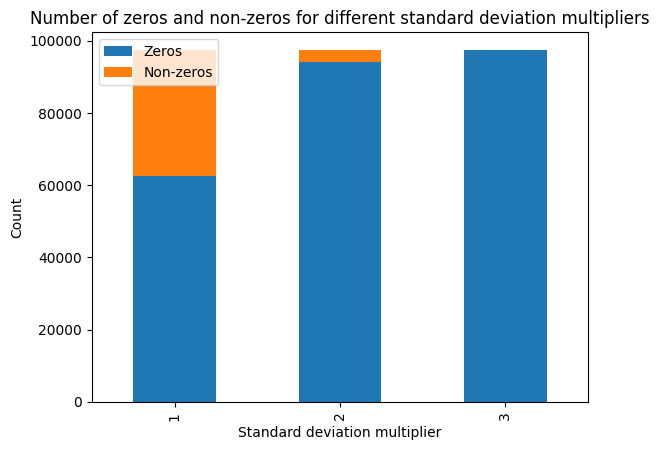

In [41]:
# Load the DataFrame from a CSV file
df_game_tags_binary = pd.read_csv('data/matrix_game_tags.csv')

df_app_id = df_game_tags_binary[['app_id']]
df_app_id.head()
print(df_app_id)
df_game_tags_binary = df_game_tags_binary.drop(['app_id','nan'], axis=1)


print(df_game_tags_binary.columns)

# Perform dimensionality reduction using SVD
num_components = 2
std_multiplier = 2 # 2nd standart devation bcz less non zeros
reduced_df = svd_reduction(df_game_tags_binary, num_components, std_multiplier)
reduced_df = reduced_df.join(df_app_id) # TODO it may not be same order
# make app_id column first column
reduced_df = reduced_df[['app_id'] + [col for col in reduced_df.columns if col != 'app_id']]
# Save the reduced DataFrame to a CSV file
reduced_df.to_csv('data/reduced_game_tags_custom_svd.csv')

# Display the reduced DataFrame
print(reduced_df)
reduced_df.head(10)

# print out the standart deviasion comparasion results
compare_std_deviations(df_game_tags_binary, num_components)

# similar_games = find_similar_games(reduced_df, 271850, threshold=0.8)
# print(similar_games)
# print(len(similar_games))




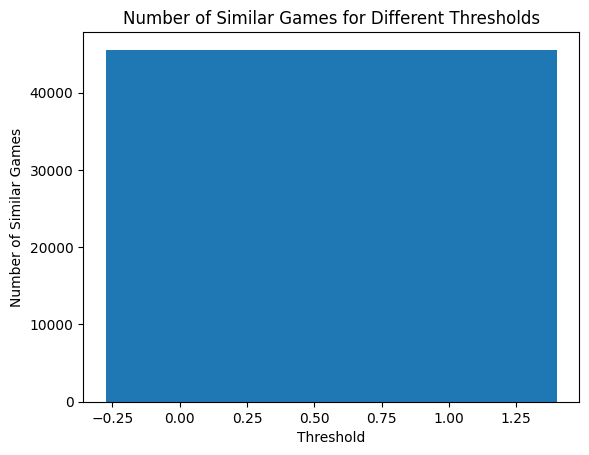

In [44]:
compare_thresholds(reduced_df, 271850, max_power=3)
